In [1]:
%matplotlib inline

import sys
sys.path.append('../')

import bisect
from collections import defaultdict
import datetime
import MySQLdb

from webhealth.analysis import AnalysisHelper
from webhealth.util import datetime_to_mysql_date

db_name='webhealth2'
username='root'
password=''

db = MySQLdb.connect(host='localhost',
                         user=username,
                         passwd=password,
                         db=db_name)

ah = AnalysisHelper(username, password, db_name)

# stable period of data
after = datetime.datetime(2015, 6, 5, 12, 57)
before = datetime.datetime(2015, 6, 6, 12, 57)

In [9]:
node_ids = ah.get_node_ids()
print "Node ids: {}".format(node_ids)

# I know that there are two nodes so far
failed_websites_0 = ah.get_failures(node_ids[0], after=after, before=before)
print "Number of failed websites {}: {}".format(node_ids[0], len(failed_websites_0))
failed_websites_1 = ah.get_failures(node_ids[1], after=after, before=before)
print "Number of failed websites {}: {}".format(node_ids[1], len(failed_websites_1))

failed = ah.find_failure_intersection(failed_websites_0, failed_websites_1, threshold_sec=60, threshold_occ=10)
print "Number of failed websites {}".format(len(failed))
print "Failed websites: {}".format(failed)

Node ids: ['aa4f2d96e411', '8b18188b10a7']
Number of failed websites aa4f2d96e411: 119
Number of failed websites 8b18188b10a7: 148


33

In [11]:
import pandas as pd

%matplotlib inline

def plot_value(query, column_name='value', *query_args):
    c = db.cursor()
    c.execute(query, query_args)
    value_res = []
    end_time_res = []
    
    for _ in range(c.rowcount):
        value, end_time = c.fetchone()

        value_res.append(float(value))
        end_time_res.append(end_time)
    c.close()

    df = pd.DataFrame({
            column_name: value_res,
            'time': end_time_res
        })
    return df.plot(x='time', figsize=(16, 12))


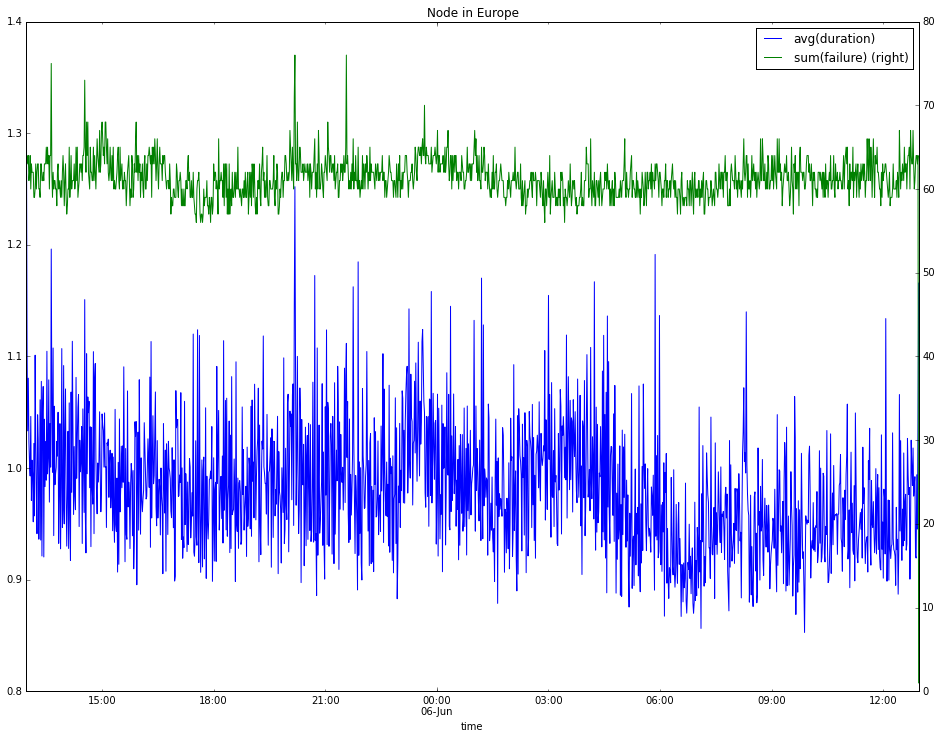

In [2]:
import pandas as pd


def plot_overal_failure_sum_and_duration_avg(node_id, title,
                                             after=datetime.datetime(1900, 1, 1), 
                                             before=datetime.datetime(9999, 1, 1)):
    c = db.cursor()
    c.execute('select avg(duration), sum(failure), end_time_1min from metrics '
              'where node_id=%s and '
              'end_time >= %s and '
              'end_time <= %s '
              'group by end_time_1min',
              (node_id, datetime_to_mysql_date(after), datetime_to_mysql_date(before),))
    duration_res = []
    failure_res = []
    end_time_res = []

    for _ in range(c.rowcount):
        duration, failure, end_time = c.fetchone()

        duration_res.append(float(duration))
        failure_res.append(int(failure))
        end_time_res.append(end_time)
    c.close()

    duration_label = 'avg(duration)'
    failure_label = 'sum(failure)'
    
    df = pd.DataFrame({
            duration_label: duration_res,
            failure_label: failure_res,
            'time': end_time_res
        })
    return df.plot(x='time', title=title, secondary_y=failure_label, figsize=(16, 12))


plot_overal_failure_sum_and_duration_avg('8b18188b10a7', 'Node in Europe', after, before)

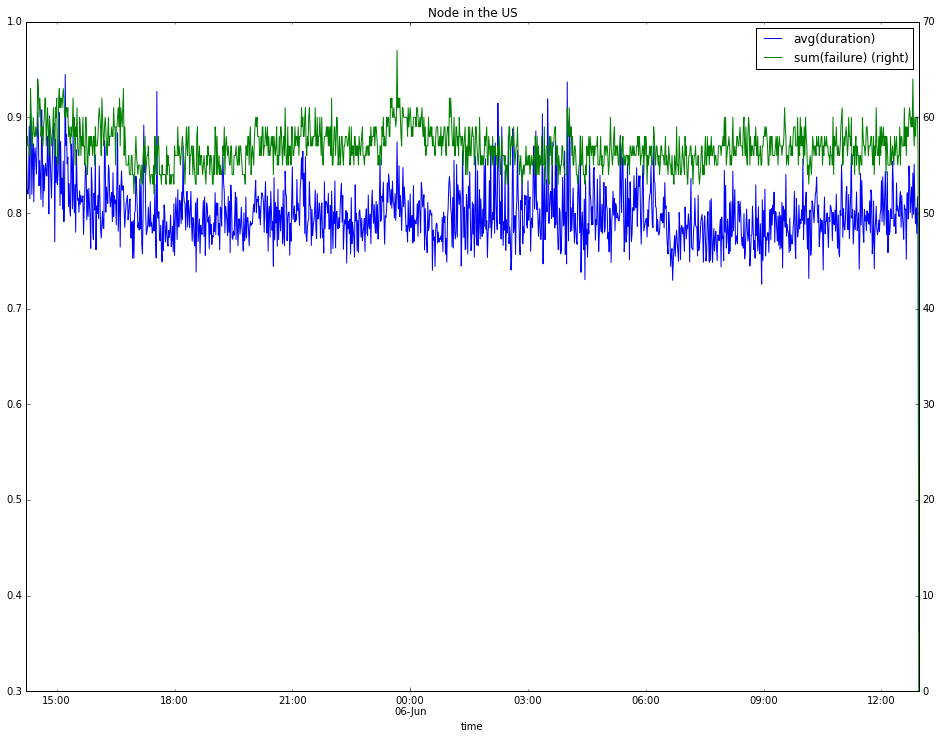

In [3]:
plot_overal_failure_sum_and_duration_avg('aa4f2d96e411', 'Node in the US', after, before)

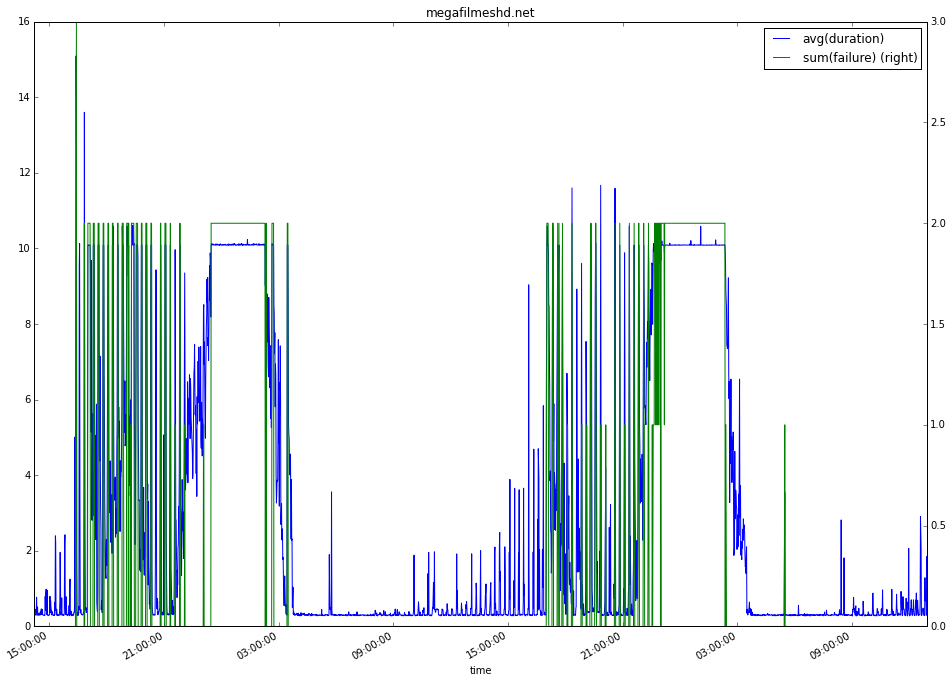

In [13]:
after_for_plot = datetime.datetime(2015, 6, 5, 12, 57)
before_for_plot = datetime.datetime(2015, 6, 7, 12, 57)

ah.plot_duration_and_failure('megafilmeshd.net', after_for_plot, before_for_plot)